In [1]:
import vllm
from mock import DataMocking
from vllm import SamplingParams
import torch
import matplotlib.pyplot as plt
import numpy as np
from simulate import simulate
from types import Tuple

/home/lrq619/anaconda3/envs/sim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-30 11:26:05,474	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:

def run_simulator(model_name: str, cuda_device_name: str, prompt_length: int, response_length: int, bsz=1) -> Tuple[float, float]:
    latencys, alpha, beta, c = simulate(
        model_name=model_name, 
        cuda_device_name=cuda_device_name, 
        prompt_length=prompt_length, 
        response_length=response_length,
        bsz=bsz
    )

    prompt_phase_latency = latencys[0]
    token_phase_latency = sum(latencys[1:])

    return prompt_phase_latency, token_phase_latency

def run_vllm(llm: vllm.LLM, cuda_device_name: str, prompt_length: int, response_length: int, bsz=1) -> Tuple[float, float]:

    data_mock = DataMocking()
    prompt = data_mock.create_prompt(prompt_token_len=prompt_length)
    prompts = [prompt for _ in range(bsz)]

    sample_param = SamplingParams(temperature=0, top_p=0.95, max_tokens=response_length, min_tokens=response_length - 1)
    outputs = llm.generate(prompts, sample_param)

    prompt_phase_latencys = []
    token_phase_latencys = []
    for output in outputs:
        metrics = output.metrics
        prompt_phase_latency = metrics.first_token_time - metrics.first_scheduled_time
        token_phase_latency = metrics.finished_time - metrics.first_token_time

        prompt_phase_latencys.append(prompt_phase_latency)
        token_phase_latencys.append(token_phase_latency)

    mean_prompt_phase_latency = np.asarray(prompt_phase_latencys).mean()
    mean_token_phase_latency = np.asarray(token_phase_latencys).mean()

    return mean_prompt_phase_latency, mean_token_phase_latency



# Evaluate Token Phase Latency Accuracy

In [2]:
model_name = "facebook/opt-6.7b"
llm = vllm.LLM(model=model_name)

if torch.cuda.is_available():
    cuda_device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"We're profiling under {cuda_device_name}")
else:
    print(f"CUDA device not available! Cannot get ptps!")
    exit(1)

prompt_length = 1024
bsz = 1

response_lengths = range(1,512,16)
sim_prompt_phase_latencys = []
gt_prompt_phase_latencys = []

sim_token_phase_latencys = []
gt_token_phase_latencys = []
for response_length in response_lengths:
    # simulated latency
    sim_prompt_phase_latency, sim_token_phase_latency = run_simulator(
        model_name=model_name,
        cuda_device_name=cuda_device_name,
        prompt_length=prompt_length,
        response_length=response_length,
        bsz=bsz,
    )
    sim_prompt_phase_latencys.append(sim_prompt_phase_latency)
    sim_token_phase_latencys.append(sim_token_phase_latency)

    # ground truth latency
    gt_prompt_phase_latency, gt_token_phase_latency = run_vllm(
        llm=llm,
        cuda_device_name=cuda_device_name,
        prompt_length=prompt_length,
        response_length=response_length,
        bsz=bsz
    )
    gt_prompt_phase_latencys.append(gt_prompt_phase_latency)
    gt_token_phase_latencys.append(gt_token_phase_latency)

sim_prompt_phase_latencys = np.asarray(sim_prompt_phase_latencys)
gt_prompt_phase_latencys = np.asarray(gt_prompt_phase_latencys)

sim_token_phase_latencys = np.asarray(sim_token_phase_latencys)
sim_token_phase_latencys *= 1.2
gt_token_phase_latencys = np.asarray(gt_token_phase_latencys)

sim_total_latencys = sim_prompt_phase_latencys + sim_token_phase_latencys
gt_total_latencys = gt_prompt_phase_latencys + gt_token_phase_latencys


/home/lrq619/anaconda3/envs/sim/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO 05-30 11:26:06 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='facebook/opt-6.7b', speculative_config=None, tokenizer='facebook/opt-6.7b', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=facebook/opt-6.7b)
INFO 05-30 11:26:06 utils.py:660] Found nccl from library /home/lrq619/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 05-30 11:26:07 selector.py:27] Using FlashAttention-2 backend.
INFO 05-30 11:26:08 weight_utils.py:199] Using model weights format ['*.bin']
INFO 05-30 11:26:21 model_runner.py:175] Loading model weights took 12.4036 GB
INFO 05-30 

Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


For gpu: NVIDIA A100 80GB PCIe, practical_mem_bw: 1200.0 GB/s, for model: facebook/opt-6.7b, kvc_size: 512.0 KB, ptps=13036.1 tokens/s


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


Average error: 0.8%


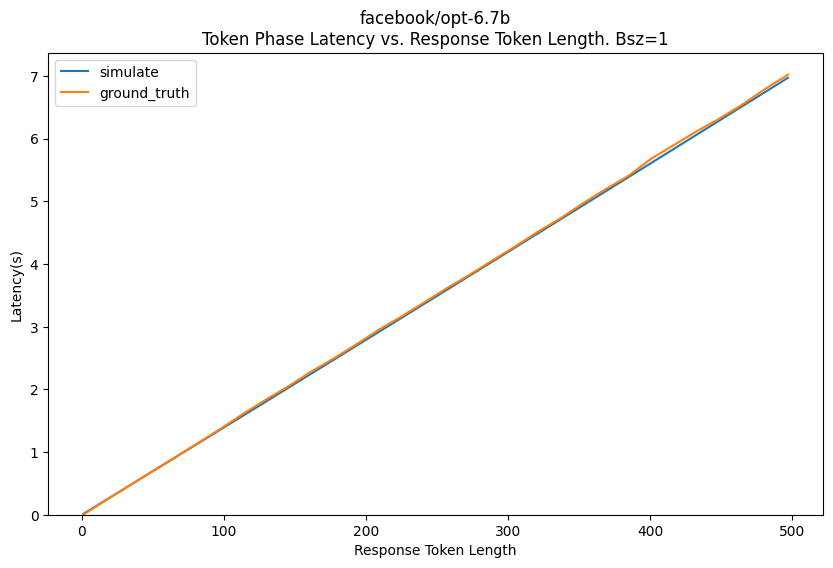

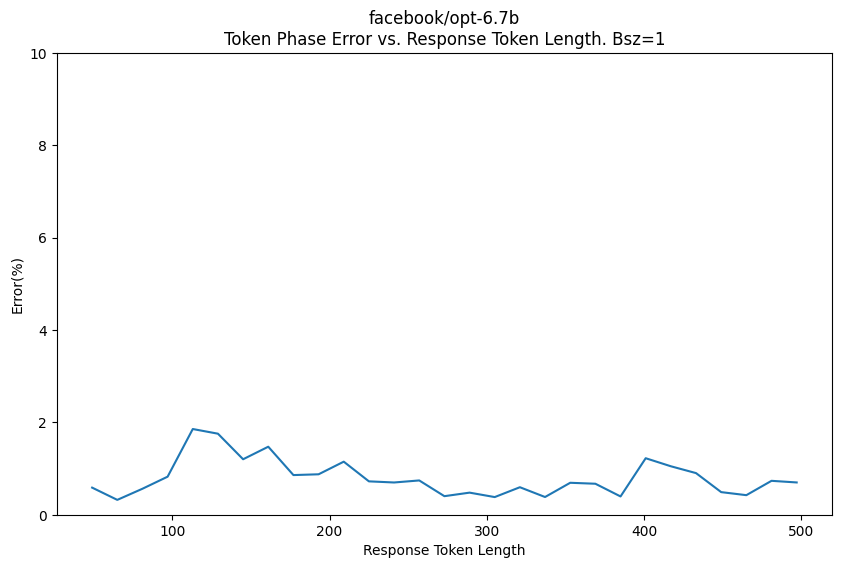

In [3]:

plt.figure(figsize=(10,6))
plt.plot(response_lengths, sim_token_phase_latencys, label="simulate")
plt.plot(response_lengths, gt_token_phase_latencys, label="ground_truth")
plt.ylim(0)
plt.legend()
plt.title(f"{model_name}\nToken Phase Latency vs. Response Token Length. Bsz={bsz}")
plt.xlabel(f"Response Token Length")
plt.ylabel(f"Latency(s)")
model_post_fix = model_name.split('/')[-1]
plt.savefig(f"results/{model_post_fix}-token-latency-bsz-{bsz}.png")


# Plot error
errors = abs((sim_token_phase_latencys - gt_token_phase_latencys) / gt_token_phase_latencys) * 100
plt.figure(figsize=(10,6))
abandon_index = 3 # we abandon the first few since it might include cuda setting up latency
plt.plot(response_lengths[3:], errors[3:])
plt.ylim(0,10)
plt.title(f"{model_name}\nToken Phase Error vs. Response Token Length. Bsz={bsz}")
plt.xlabel(f"Response Token Length")
plt.ylabel(f"Error(%)")
print(f"Average error: {errors[3:].mean():.1f}%")
plt.savefig(f"results/{model_post_fix}-error-{bsz}.png")

# Evaluate Total Latency

Average error: 1.1%


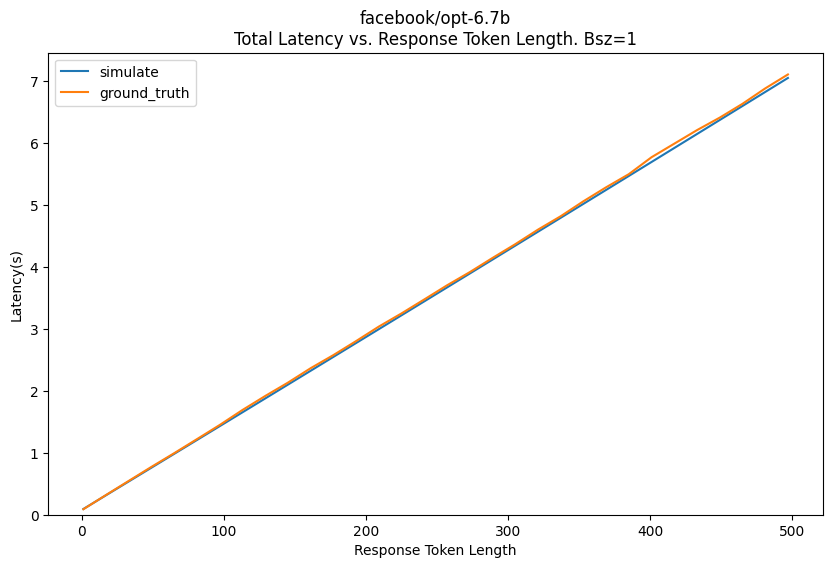

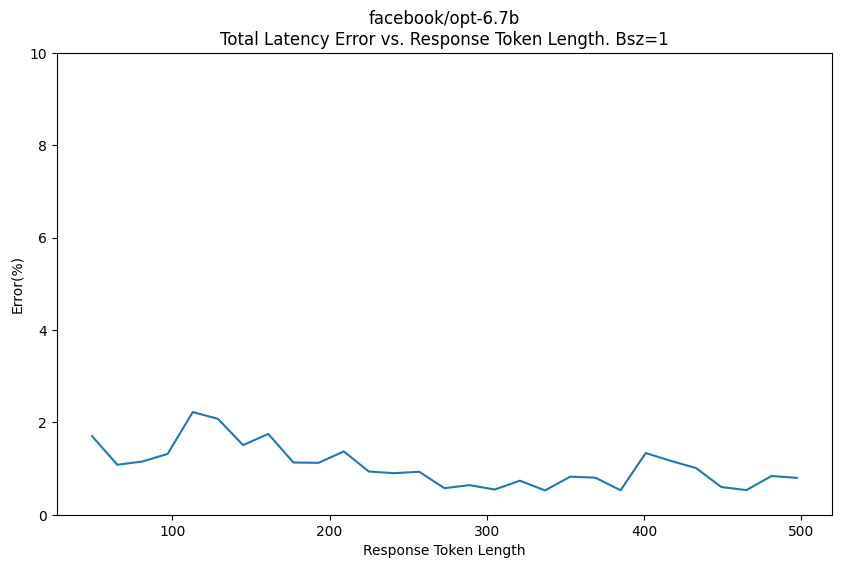

In [4]:

plt.figure(figsize=(10,6))
plt.plot(response_lengths, sim_total_latencys, label="simulate")
plt.plot(response_lengths, gt_total_latencys, label="ground_truth")
plt.ylim(0)
plt.legend()
plt.title(f"{model_name}\nTotal Latency vs. Response Token Length. Bsz={bsz}")
plt.xlabel(f"Response Token Length")
plt.ylabel(f"Latency(s)")
model_post_fix = model_name.split('/')[-1]
plt.savefig(f"results/{model_post_fix}-total-latency-bsz-{bsz}.png")


# Plot error
errors = abs((sim_total_latencys - gt_total_latencys) / gt_total_latencys) * 100
plt.figure(figsize=(10,6))
abandon_index = 3 # we abandon the first few since it might include cuda setting up latency
plt.plot(response_lengths[3:], errors[3:])
plt.ylim(0,10)
plt.title(f"{model_name}\nTotal Latency Error vs. Response Token Length. Bsz={bsz}")
plt.xlabel(f"Response Token Length")
plt.ylabel(f"Error(%)")
print(f"Average error: {errors[3:].mean():.1f}%")
plt.savefig(f"results/{model_post_fix}-total-error-{bsz}.png")